# Identify generic genes and pathways

**This notebook performs the following steps to identify generic genes:**
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene
3. For each gene, aggregate statsitics across all simulated experiments 
4. Rank genes based on this aggregated statistic (i.e. log fold change, or p-value)


**This notebook performs the following steps to identify generic gene sets (pathways):**
1. Using the same simulated experiments from above, perform GSEA analysis. This analysis will determine whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list of genes, where genes are ranked by log fold change, indicating a correlation with change in expression.
2. For each gene set (pathway), aggregate statistics across all simulated experiments
3. Rank gene sets based on this aggregated statistic

**Evaluation:**
* We want to compare the ranking of genes identified using the above method with the ranking found from Crow et. al., which identified a set of genes as generic based on their ranking;
* We want to compare the ranking of pathways identified using the above method with the ranking found from Powers et. al., which identified a set of pathways as generic based on their ranking;
* This comparison will validate our method being used as a way to automatically identify generic genes and pathways.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import pickle

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from ponyo import utils
from generic_expression_patterns_modules import calc, process

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_validate.tsv")
)

params = utils.read_config(config_filename)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
metadata_col_id = params['metadata_colname']
processed_template_filename = params['processed_template_filename']
normalized_compendium_filename = params['normalized_compendium_filename']
scaler_filename = params['scaler_filename']
col_to_rank_genes = params['rank_genes_by']
col_to_rank_pathways = params['rank_pathways_by']
compare_genes = params['compare_genes']
statistic = params['gsea_statistic']

# Load metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv"
)

# Load pickled file
with open(scaler_filename, "rb") as scaler_fh:
    scaler = pickle.load(scaler_fh)

In [4]:
# Output files
gene_summary_filename = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_gene_summary_{project_id}.tsv"
)

pathway_summary_filename = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_pathway_summary_{project_id}.tsv"
)

## Need to customize code from ponyo for Rani's dataset

Should we update ponyo? Changes should include:
* `get_sample_ids` to use arguments: metadata_filename, delimiter, experiment_colname, sample_id_colname
* `shift_template_experiment` will need to add arguments for metadata_filename, delimiter, experiment_colname
* `simulate_by_latent_transformation` will also need to be updated with these arguments and testing will need to be done to make sure old analysis runs

I think these new changes will make ponyo more usable and should be done, not necessarily for this analysis so this will probably need to slotted as lower priority. Issue in ponyo is [here](https://github.com/greenelab/ponyo/issues/18) 

In [5]:
def get_sample_ids(experiment_id, dataset_name, sample_id_colname):
    """
    Returns sample ids (found in gene expression df) associated with
    a given list of experiment ids (found in the metadata)

    Arguments
    ----------
    experiment_ids_file: str
        File containing all cleaned experiment ids

    dataset_name: str
        Name for analysis directory. Either "Human" or "Pseudomonas"

    sample_id_colname: str
        Column header that contains sample id that maps expression data
        and metadata

    """
    base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

    # Read in metadata
    metadata = pd.read_csv(metadata_filename, header=0)
    metadata.set_index("gse", inplace=True)

    selected_metadata = metadata.loc[experiment_id]
    sample_ids = list(selected_metadata[sample_id_colname])

    return sample_ids

In [6]:
import glob
from keras.models import load_model

def shift_template_experiment(
    normalized_data_file,
    selected_experiment_id,
    sample_id_colname,
    NN_architecture,
    dataset_name,
    scaler,
    local_dir,
    base_dir,
    run,
    metadata_filename,
):
    """
    Generate new simulated experiment using the selected_experiment_id as a template
    experiment using the same workflow as `simulate_by_latent_transform`

    This will return a file with a single simulated experiment following the workflow mentioned.
    This function can be run multiple times to generate multiple simulated experiments from a
    single selected_experiment_id.

    Arguments
    ----------
    normalized_data_file: str
        File containing normalized gene expression data

        ------------------------------| PA0001 | PA0002 |...
        05_PA14000-4-2_5-10-07_S2.CEL | 0.8533 | 0.7252 |...
        54375-4-05.CEL                | 0.7789 | 0.7678 |...
        ...                           | ...    | ...    |...

    selected_experiment_id: str
        Experiment id selected as template

    sample_id_colname: str
        Column header that contains sample id that maps expression data and metadata

    NN_architecture: str
        Name of neural network architecture to use.
        Format 'NN_<intermediate layer>_<latent layer>'

    dataset_name: str
        Name for analysis directory. Either "Human" or "Pseudomonas"

    scaler: minmax model
        Model used to transform data into a different range

    local_dir: str
        Parent directory on local machine to store intermediate results

    base_dir: str
        Root directory containing analysis subdirectories

    run: int
        Simulation run

    Returns
    --------
    simulated_data_file: str
        File containing simulated gene expression data

    """

    # Files
    NN_dir = os.path.join(base_dir, dataset_name, "models", NN_architecture)
    latent_dim = NN_architecture.split("_")[-1]

    model_encoder_file = glob.glob(os.path.join(NN_dir, "*_encoder_model.h5"))[0]

    weights_encoder_file = glob.glob(os.path.join(NN_dir, "*_encoder_weights.h5"))[0]

    model_decoder_file = glob.glob(os.path.join(NN_dir, "*_decoder_model.h5"))[0]

    weights_decoder_file = glob.glob(os.path.join(NN_dir, "*_decoder_weights.h5"))[0]

    # Load saved models
    loaded_model = load_model(model_encoder_file, compile=False)
    loaded_decode_model = load_model(model_decoder_file, compile=False)

    loaded_model.load_weights(weights_encoder_file)
    loaded_decode_model.load_weights(weights_decoder_file)

    # Read data
    normalized_data = pd.read_csv(normalized_data_file, header=0, sep="\t", index_col=0)

    # Get corresponding sample ids
    sample_ids = get_sample_ids(selected_experiment_id, metadata_filename, sample_id_colname)

    # Gene expression data for selected samples
    selected_data_df = normalized_data.loc[sample_ids]

    # Encode selected experiment into latent space
    data_encoded = loaded_model.predict_on_batch(selected_data_df)
    data_encoded_df = pd.DataFrame(data_encoded, index=selected_data_df.index)

    # Get centroid of original data
    centroid = data_encoded_df.mean(axis=0)

    # Add individual vectors(centroid, sample point) to new_centroid

    # Encode original gene expression data into latent space
    data_encoded_all = loaded_model.predict_on_batch(normalized_data)
    data_encoded_all_df = pd.DataFrame(data_encoded_all, index=normalized_data.index)

    data_encoded_all_df.head()

    # Find a new location in the latent space by sampling from the latent space
    encoded_means = data_encoded_all_df.mean(axis=0)
    encoded_stds = data_encoded_all_df.std(axis=0)

    latent_dim = int(latent_dim)
    new_centroid = np.zeros(latent_dim)

    for j in range(latent_dim):
        new_centroid[j] = np.random.normal(encoded_means[j], encoded_stds[j])

    shift_vec_df = new_centroid - centroid
    # print(shift_vec_df)

    simulated_data_encoded_df = data_encoded_df.apply(
        lambda x: x + shift_vec_df, axis=1
    )

    # Decode simulated data into raw gene space
    simulated_data_decoded = loaded_decode_model.predict_on_batch(
        simulated_data_encoded_df
    )

    simulated_data_decoded_df = pd.DataFrame(
        simulated_data_decoded,
        index=simulated_data_encoded_df.index,
        columns=selected_data_df.columns,
    )

    # Un-normalize the data in order to run DE analysis downstream
    simulated_data_scaled = scaler.inverse_transform(simulated_data_decoded_df)

    simulated_data_scaled_df = pd.DataFrame(
        simulated_data_scaled,
        columns=simulated_data_decoded_df.columns,
        index=simulated_data_decoded_df.index,
    )

    # Save template data for visualization validation
    test_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        "template_normalized_data_" + selected_experiment_id + "_test.txt",
    )

    selected_data_df.to_csv(test_file, float_format="%.3f", sep="\t")

    # Save
    out_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        "selected_simulated_data_" + selected_experiment_id + "_" + str(run) + ".txt",
    )

    simulated_data_scaled_df.to_csv(out_file, float_format="%.3f", sep="\t")

    out_encoded_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_encoded_data_{selected_experiment_id}_{run}.txt",
    )

    simulated_data_encoded_df.to_csv(out_encoded_file, float_format="%.3f", sep="\t")

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

### Simulate experiments using selected template experiment

In [7]:
# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "all_experiments_sample_annotations.csv"
)

In [8]:
"""# Simulate multiple experiments
# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:           
#   - selected_simulated_data_SRP012656_<n>.txt
#   - selected_simulated_encoded_data_SRP012656_<n>.txt
#   - template_normalized_data_SRP012656_test.txt
# in which "<n>" is an integer in the range of [0, num_runs-1] 
os.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)
for run_id in range(num_runs):
    shift_template_experiment(
        normalized_compendium_filename,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        run_id,
        metadata_filename
    )"""

'# Simulate multiple experiments\n# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:           \n#   - selected_simulated_data_SRP012656_<n>.txt\n#   - selected_simulated_encoded_data_SRP012656_<n>.txt\n#   - template_normalized_data_SRP012656_test.txt\n# in which "<n>" is an integer in the range of [0, num_runs-1] \nos.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)\nfor run_id in range(num_runs):\n    shift_template_experiment(\n        normalized_compendium_filename,\n        project_id,\n        metadata_col_id,\n        NN_architecture,\n        dataset_name,\n        scaler,\n        local_dir,\n        base_dir,\n        run_id,\n        metadata_filename\n    )'

Since this experiment contains multiple conditions (i.e. estradiol vs EtOH at 12, 24, and 48 hrs are each considered a different comparison) being tested, we will only include those samples within the same condition. 

In [9]:
"""# This step modifies the following files:
# "<local_dir>/pseudo_experiments/selected_simulated_data_SRP012656_<n>.txt"
if os.path.exists(sample_id_metadata_filename):
    # Read in metadata
    metadata = pd.read_csv(sample_id_metadata_filename, sep='\t', header=0, index_col=0)
    
    # Get samples to be dropped
    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)

    process.subset_samples(
        sample_ids_to_drop,
        num_runs,
        local_dir,
        project_id
    )"""

'# This step modifies the following files:\n# "<local_dir>/pseudo_experiments/selected_simulated_data_SRP012656_<n>.txt"\nif os.path.exists(sample_id_metadata_filename):\n    # Read in metadata\n    metadata = pd.read_csv(sample_id_metadata_filename, sep=\'\t\', header=0, index_col=0)\n    \n    # Get samples to be dropped\n    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)\n\n    process.subset_samples(\n        sample_ids_to_drop,\n        num_runs,\n        local_dir,\n        project_id\n    )'

### Differential expression analysis

The gene expression dataset is array-based so we will use Limma in this case

In [10]:
# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_groups.tsv"
)

In [11]:
# Check whether ordering of sample ids is consistent between gene expression data and metadata
process.compare_and_reorder_samples(processed_template_filename, metadata_filename)

sample ids are ordered correctly


In [12]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [13]:
%%R -i metadata_filename -i project_id -i processed_template_filename -i local_dir

source('../generic_expression_patterns_modules/DE_analysis.R')

# File created: "<local_dir>/DE_stats/DE_stats_template_data_SRP012656_real.txt"
get_DE_stats_limma(metadata_filename,
                   project_id, 
                   processed_template_filename,
                   "template",
                   local_dir,
                   "real")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarni

[1] 31


In [14]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

selected = template_DE_stats[(template_DE_stats['adj.P.Val']<0.05) & (abs(template_DE_stats['logFC'])>1)]
print(selected.shape)

(33, 6)


In [15]:
# Check whether ordering of sample ids is consistent between gene expression data and metadata
for i in range(num_runs):
    simulated_data_filename = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt"
    )
        
    process.compare_and_reorder_samples(simulated_data_filename, metadata_filename)

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


In [16]:
%%R -i metadata_filename -i project_id -i base_dir -i local_dir -i num_runs

source('../generic_expression_patterns_modules/DE_analysis.R')

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_SRP012656_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(local_dir, 
                                     "pseudo_experiment/selected_simulated_data_",
                                     project_id,
                                     "_", 
                                     i,
                                     ".txt",
                                     sep = "")
    
    get_DE_stats_limma(metadata_filename,
                       project_id, 
                       simulated_data_filename,
                       "simulated",
                       local_dir,
                       i)
}

### Rank genes

In [17]:
# Concatenate simulated experiments
simulated_DE_stats_all = process.concat_simulated_data(local_dir, num_runs, project_id, 'DE')

print(simulated_DE_stats_all.shape)

(169075, 7)


In [18]:
# Take absolute value of logFC and t statistic
simulated_DE_stats_all = process.abs_value_stats(simulated_DE_stats_all)

In [19]:
# Aggregate statistics across all simulated experiments
simulated_DE_summary_stats = calc.aggregate_stats(
    col_to_rank_genes,
    simulated_DE_stats_all,
    'DE'
)

In [20]:
# Take absolute value of logFC and t statistic
template_DE_stats = process.abs_value_stats(template_DE_stats)

# Rank genes in template experiment
template_DE_stats = calc.rank_genes_or_pathways(
    col_to_rank_genes,      
    template_DE_stats,
    True
)

In [21]:
# Rank genes in simulated experiments
simulated_DE_summary_stats = calc.rank_genes_or_pathways(
    col_to_rank_genes,
    simulated_DE_summary_stats,
    False
)

### Gene summary table

In [22]:
summary_gene_ranks = process.generate_summary_table(
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir
)

summary_gene_ranks.head()

(6763, 13)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
EGR3,EGR3,4.265860e-09,6763.0,3.945807,0.013095,6656.0,0.079667,0.056222,25,68.765281
PGR,PGR,9.812526e-07,6762.0,2.620937,0.053752,6384.0,0.059093,0.040775,25,62.828487
PRSS23,PRSS23,1.683715e-06,6761.0,2.557864,0.197364,6035.5,0.044933,0.041886,25,59.994390
MYBL1,MYBL1,3.661078e-06,6760.0,1.919970,0.030567,6655.0,0.087307,0.047899,25,38.261297
CXCL12,CXCL12,1.083478e-05,6759.0,1.834330,0.007318,6661.5,0.081360,0.038029,25,46.095051


In [23]:
# Create `gene_summary_fielname`
summary_gene_ranks.to_csv(gene_summary_filename, sep='\t')

### Compare gene ranking
Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represent a more systematic change. 

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

r = 0.32918582536172053
p = 7.633076397458203e-162
ci_low = 0.30689331681390825
ci_high = 0.3511604325208161


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


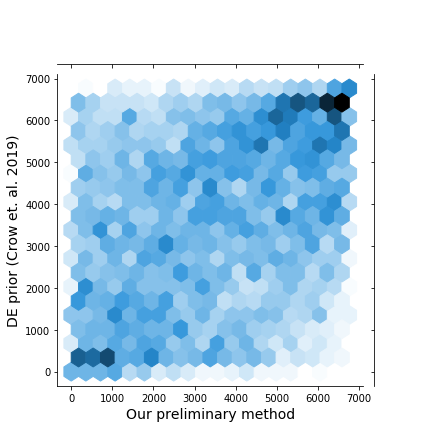

In [24]:
if compare_genes:
    # Get generic genes identified by Crow et. al.
    DE_prior_file = params['reference_gene_filename']
    ref_gene_col = params['reference_gene_name_col']
    ref_rank_col = params['reference_rank_col']
    
    figure_filename = os.path.join(
        local_dir, 
        f"gene_ranking_{col_to_rank_genes}.svg"
    )
    
    process.compare_gene_ranking(
        summary_gene_ranks,
        DE_prior_file,
        ref_gene_col,
        ref_rank_col,
        figure_filename
    )

**Takeaway:**
* Previously we compared gene ranks obtained from recount2-trained VAE model vs Crow et. al. This [PR](https://github.com/ajlee21/generic-expression-patterns/blob/807377d76f63b6282c62255d7b160feb8585e0e2/human_analysis/2_identify_generic_genes_pathways.ipynb) shows that the correlation of gene ranks are very consistent.

* Here we are comparing gene ranks obtained from a Powers et. al.-trained VAE model vs Crow et. al. Based on this correlation plot there is a high correlation between those very high and low ranked genes. But there is a lot of noise in the middle.

* **Q**: Why is the correlation between recount2-VAE and Crow et. al. higher than Powers et. al.-VAE and Crow et. al.?
* Both Powers et. al. and Crow et. al. use array data. But the Crow et all dataset is mixed array data and the Powers et. al. data is cancer specific.

### GSEA 
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Rank all genes using DE association statistics. In this case we used the p-value scores to rank genes. logFC returned error -- need to look into this.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES (i.e. scores based on permuted phenotype)

In [25]:
# Load pathway data
hallmark_DB_filename = os.path.join(local_dir, "hallmark_DB.gmt")

In [26]:
%%R -i base_dir -i template_DE_stats_filename -i hallmark_DB_filename -i statistic -i local_dir -o template_enriched_pathways

source(paste(base_dir, 'generic_expression_patterns_modules/GSEA_analysis.R', sep='/'))

template_enriched_pathways <- find_enriched_pathways(template_DE_stats_filename, hallmark_DB_filename, statistic)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: Rcpp

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [27]:
print(template_enriched_pathways.shape)
template_enriched_pathways[template_enriched_pathways['padj'] < 0.05].sort_values(by='padj').head(10)

(50, 8)


,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
14,HALLMARK_ESTROGEN_RESPONSE_EARLY,0.000175,0.002934,0.854415,2.944347,0.0,65,None
15,HALLMARK_ESTROGEN_RESPONSE_LATE,0.000176,0.002934,0.826175,2.787993,0.0,57,None
31,HALLMARK_MYC_TARGETS_V1,0.000176,0.002934,0.750681,2.491027,0.0,52,None
26,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.000463,0.005782,-0.557724,-1.953200,1.0,53,None
12,HALLMARK_E2F_TARGETS,0.000904,0.009045,0.625182,1.958190,4.0,39,None
32,HALLMARK_MYC_TARGETS_V2,0.001321,0.011006,0.804683,1.969322,6.0,13,None
25,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.003054,0.019088,-0.627691,-1.842285,13.0,24,None
45,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.003051,0.019088,0.589271,1.838916,16.0,38,None
5,HALLMARK_APICAL_SURFACE,0.008010,0.040051,-0.729707,-1.753227,37.0,11,None
24,HALLMARK_INFLAMMATORY_RESPONSE,0.007702,0.040051,-0.405263,-1.538516,31.0,81,None


In [28]:
# Create "<local_dir>/GSEA_stats/" subdirectory
os.makedirs(os.path.join(local_dir, "GSEA_stats"), exist_ok=True)

In [29]:
%%R -i project_id -i local_dir -i hallmark_DB_filename -i num_runs -i statistic

source('../generic_expression_patterns_modules/GSEA_analysis.R')

# New files created: "<local_dir>/GSEA_stats/GSEA_stats_simulated_data_<project_id>_<n>.txt"
for (i in 0:(num_runs-1)) {
    simulated_DE_stats_file <- paste(local_dir, 
                                     "DE_stats/DE_stats_simulated_data_", 
                                     project_id,
                                     "_", 
                                     i,
                                     ".txt",
                                     sep = "")
    
    out_file <- paste(local_dir, 
                     "GSEA_stats/GSEA_stats_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt", 
                     sep = "")
    
    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_file, hallmark_DB_filename, statistic) 
    
    # Remove column with leading edge since its causing parsing issues
    write.table(as.data.frame(enriched_pathways[1:7]), file = out_file, row.names = F, sep = "\t")
}

### Rank pathways 

In [30]:
# Concatenate simulated experiments
simulated_GSEA_stats_all = process.concat_simulated_data(local_dir, num_runs, project_id, 'GSEA')
simulated_GSEA_stats_all.set_index('pathway', inplace=True)
print(simulated_GSEA_stats_all.shape)

(1250, 6)


In [31]:
# Aggregate statistics across all simulated experiments
simulated_GSEA_summary_stats = calc.aggregate_stats(
    col_to_rank_pathways,
    simulated_GSEA_stats_all,
    'GSEA'
)

simulated_GSEA_summary_stats.head()

padj                          
                                median      mean       std count
pathway                                                         
HALLMARK_ADIPOGENESIS         0.485682  0.498442  0.187892    25
HALLMARK_ALLOGRAFT_REJECTION  0.002064  0.032172  0.084605    25
HALLMARK_ANDROGEN_RESPONSE    0.412621  0.401638  0.208488    25
HALLMARK_ANGIOGENESIS         0.255055  0.350826  0.273714    25
HALLMARK_APICAL_JUNCTION      0.270362  0.284261  0.219078    25

In [32]:
# Load association statistics for template experiment
template_GSEA_stats = template_enriched_pathways.iloc[:, :-1]
template_GSEA_stats.set_index('pathway', inplace=True)

template_GSEA_stats.head()

# Rank genes in template experiment
template_GSEA_stats = calc.rank_genes_or_pathways(
    col_to_rank_pathways,
    template_GSEA_stats,
    True
)

In [33]:
# Rank genes in simulated experiments
simulated_GSEA_summary_stats = calc.rank_genes_or_pathways(
    col_to_rank_pathways,
    simulated_GSEA_summary_stats,
    False
)

### Pathway summary table

In [34]:
# Create intermediate file: "<local_dir>/gene_summary_table_<col_to_rank_pathways>.tsv"
summary_pathway_ranks = process.generate_summary_table(
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
    col_to_rank_pathways,
    local_dir
)

summary_pathway_ranks.head()

(50, 12)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
pathway,,,,,,,,,,
HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,0.002934,49.0,0.002934,0.119061,29.0,0.206387,0.213446,25,-0.953182
HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,0.002934,49.0,0.002934,0.100207,31.0,0.201498,0.238074,25,-0.834044
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,0.002934,49.0,0.002934,0.001567,49.0,0.010622,0.035317,25,-0.217664
HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.005782,47.0,0.005782,0.001891,46.5,0.043580,0.148563,25,-0.254428
HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,0.009045,46.0,0.009045,0.001567,49.0,0.053306,0.174789,25,-0.253226


In [35]:
# Create `pathway_summary_filename`
#summary_pathway_ranks.to_csv(pathway_summary_filename, sep='\t')

### Compare pathway ranking try 1

Studies have found that there are some pathways (gene sets) that are more likely to be significantly enriched in DEGs across a wide range of experimental designs. These generic pathways are not necessarily specific to the biological process being studied but instead represents a more systematic change.

We want to compare the ability to detect these generic pathways using our method vs those found by [Powers et. al.](https://www.biorxiv.org/content/10.1101/259440v1.full.pdf) publication.  We will use the `Hallmarks_qvalues_GSEAPreranked.csv` file from https://www.synapse.org/#!Synapse:syn11806255 as a reference. The file contains the q-value (adjusted p-value) for the test: given the enrichment score (ES) of the experiment is significant compared to the null distribution of enrichment scores, where the null set is generated from permuted gene sets. For each gene set (pathway) they calculate the q-value using this test. 


To get a `reference ranking`, we calculate the fraction of experiments that a given pathway was significant (q-value <0.05) and use this rank pathways. `Our ranking` is to rank pathways based on the median q-value across the simulated experiments. We can then compare `our ranking` versus the `reference ranking.`

In [36]:
# Load Powers et. al. results file
powers_rank_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_qvalues_GSEAPreranked.csv"
)

In [37]:
# Read Powers et. al. data
# This file contains qvalue results for hallmark pathways across ~400 experiments
powers_rank_df = pd.read_csv(powers_rank_filename, header=0, index_col=0)
powers_rank_df.drop(['Category'], axis=1, inplace=True)
print(powers_rank_df.shape)
powers_rank_df.head()

(50, 443)


,GSE10281_DEG_Expt1_Control_vs_Group1_qval,GSE10299_DEG_Expt1_Control_vs_Group1_qval,GSE10299_DEG_Expt1_Control_vs_Group2_qval,GSE10311_DEG_Expt1_Control_vs_Group1_qval,GSE10410_DEG_Expt1_Control_vs_Group1_qval,GSE10410_DEG_Expt1_Control_vs_Group2_qval,GSE10592_DEG_Expt1_Control_vs_Group1_qval,GSE10592_DEG_Expt2_Control_vs_Group1_qval,GSE11142_DEG_Expt1_Control_vs_Group1_qval,GSE11285_DEG_Expt1_Control_vs_Group1_qval,...,GSE79761_DEG_Expt1_Control_vs_Group2_qval,GSE79761_DEG_Expt1_Control_vs_Group3_qval,GSE83120_DEG_Expt1_Control_vs_Group1_qval,GSE83491_DEG_Expt1_Control_vs_Group1_qval,GSE83491_DEG_Expt2_Control_vs_Group1_qval,GSE8588_DEG_Expt1_Control_vs_Group1_qval,GSE8588_DEG_Expt1_Control_vs_Group2_qval,GSE8597_DEG_Expt1_Control_vs_Group1_qval,GSE8658_DEG_Expt1_Control_vs_Group1_qval,GSE9988_DEG_Expt1_Control_vs_Group1_qval
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_APICAL_JUNCTION,0.010497,0.994108,0.045536,0.498151,0.538082,0.429205,0.355439,0.236627,0.767614,0.858065,...,0.637333,0.019621,0.086923,0.453315,0.730539,0.005366,0.863592,0.102867,0.639821,0.465678
HALLMARK_APICAL_SURFACE,0.443835,0.598008,0.181818,0.407927,0.130422,0.588732,0.192183,0.003519,1.000000,0.809823,...,0.260565,0.018686,0.691567,0.588169,1.000000,0.172392,0.657082,0.008060,0.618102,0.229456
HALLMARK_PEROXISOME,0.110897,0.988705,0.118807,0.094770,0.004288,0.115514,0.172297,0.035202,0.682219,0.393990,...,0.447485,0.380294,0.058549,0.110354,0.215365,0.006037,0.034110,0.331770,0.005224,1.000000
HALLMARK_ADIPOGENESIS,0.011177,0.461255,0.171288,0.020412,0.010720,0.000000,0.191663,0.846586,0.895637,0.056589,...,0.604963,0.805532,0.054415,0.022888,0.000000,0.735339,0.636778,0.649874,0.000000,0.435622
HALLMARK_ANGIOGENESIS,0.006014,0.380219,0.663985,0.992954,0.175682,0.010256,0.004750,0.015640,1.000000,0.402218,...,0.007489,0.023545,0.965871,0.035213,0.646400,0.004025,0.209530,0.007165,0.181685,0.108067


In [38]:
# Count the number of experiments where a given pathway was found to be enriched (qvalue < 0.05)
total_num_experiments = powers_rank_df.shape[1]
frac_enriched_pathways = ((powers_rank_df < 0.05).sum(axis=1) / total_num_experiments)

# Rank pathways from 0-50, 50 indicating that the pathways was frequently enriched
pathway_ranks = frac_enriched_pathways.rank()

powers_rank_stats_df = pd.DataFrame(
    data={
        'Fraction enriched': frac_enriched_pathways.values,
        'Powers Rank':pathway_ranks.values
    },
    index=powers_rank_df.index
)
powers_rank_stats_df.head()

,Fraction enriched,Powers Rank
Term,,
HALLMARK_APICAL_JUNCTION,0.124153,4.0
HALLMARK_APICAL_SURFACE,0.128668,5.5
HALLMARK_PEROXISOME,0.148984,7.5
HALLMARK_ADIPOGENESIS,0.182844,15.0
HALLMARK_ANGIOGENESIS,0.191874,16.5


In [39]:
# Save reference file for input into comparison
powers_rank_processed_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_qvalues_GSEAPreranked_processed.tsv"
)

powers_rank_stats_df.to_csv(powers_rank_processed_filename, sep="\t", )

r = 0.6513259039029995
p = 3.021430225614252e-07
ci_low = 0.4128184372815132
ci_high = 0.8149823187905113


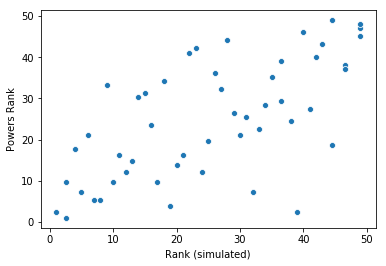

In [40]:
if compare_genes:
    process.compare_pathway_ranking(
        summary_pathway_ranks,
        powers_rank_processed_filename,
    )

* Our method ranked pathways using median adjusted p-value score across simulated experiments.
* Powers et. al. ranked pathways based on the fraction of experiments they had adjusted p-value < 0.05.
* Next let's try to use the fraction of adjusted p-value < 0.05 for our method and re-compare (below)

**Takeaway:**
* Previously we compared pathway ranks obtained from recount2-trained VAE model vs Powers et. al. This [PR](https://github.com/ajlee21/generic-expression-patterns/blob/807377d76f63b6282c62255d7b160feb8585e0e2/human_analysis/2_identify_generic_genes_pathways.ipynb) shows that there was no correlation.

* Here we are comparing pathway ranks obtained from a Powers et. al.-trained VAE model vs Powers et. al. Based on this correlation plot there is a high correlation.

* **Q**: Why is the correlation between recount2-VAE and Powers et. al. nonexistent, but the Powers et. al.-VAE and Powers et. al.?
* Recount2 dataset is mixed while the Powers et. al. data is cancer specific. 

**Is this sufficient to conclude that training dataset matters?**

In [41]:
# Rank pathways based on the proportion of times they appear significant
simulated_GSEA_stats_all["significant"] = simulated_GSEA_stats_all['padj'] < 0.05
simulated_GSEA_stats_all_new = (
    simulated_GSEA_stats_all.groupby(
        ['pathway']
    )["significant"].sum() / num_runs
).to_frame(name="Fraction enriched")
simulated_GSEA_stats_all_new["Rank (simulated)"] = simulated_GSEA_stats_all_new.rank()

print(simulated_GSEA_stats_all_new.shape)
simulated_GSEA_stats_all_new.head()

(50, 2)


,Fraction enriched,Rank (simulated)
pathway,,
HALLMARK_ADIPOGENESIS,0.00,7.0
HALLMARK_ALLOGRAFT_REJECTION,0.88,45.5
HALLMARK_ANDROGEN_RESPONSE,0.08,17.0
HALLMARK_ANGIOGENESIS,0.12,20.5
HALLMARK_APICAL_JUNCTION,0.24,27.0


r = 0.593304707452075
p = 5.6057616329494785e-06
ci_low = 0.35193244629125103
ci_high = 0.7631687490168417


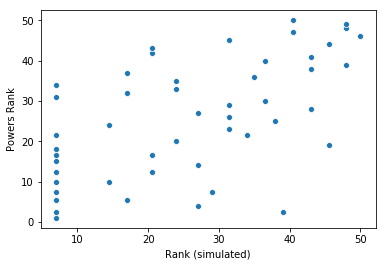

In [42]:
if compare_genes:
    process.compare_pathway_ranking(
        simulated_GSEA_stats_all_new,
        powers_rank_processed_filename,
    )

Instead we will try to use the normalized ES (NES) values to rank the pathways for this next try.

## Compare rank pathways try 2

In [43]:
# Take absolute value of logFC and t statistic
#simulated_GSEA_stats_all = process.abs_value_stats(simulated_GSEA_stats_all)

In [44]:
"""# Aggregate statistics across all simulated experiments
simulated_GSEA_summary_stats = calc.aggregate_stats(
    'NES',
    simulated_GSEA_stats_all,
    'GSEA'
)

simulated_GSEA_summary_stats.head()"""

"# Aggregate statistics across all simulated experiments\nsimulated_GSEA_summary_stats = calc.aggregate_stats(\n    'NES',\n    simulated_GSEA_stats_all,\n    'GSEA'\n)\n\nsimulated_GSEA_summary_stats.head()"

In [45]:
"""# Take absolute value of NES
template_GSEA_stats = process.abs_value_stats(template_GSEA_stats)

# Rank genes in template experiment
template_GSEA_stats = calc.rank_genes_or_pathways(
    'NES',
    template_GSEA_stats,
    True
)"""

"# Take absolute value of NES\ntemplate_GSEA_stats = process.abs_value_stats(template_GSEA_stats)\n\n# Rank genes in template experiment\ntemplate_GSEA_stats = calc.rank_genes_or_pathways(\n    'NES',\n    template_GSEA_stats,\n    True\n)"

In [46]:
"""# Rank genes in simulated experiments
simulated_GSEA_summary_stats = calc.rank_genes_or_pathways(
    'NES',
    simulated_GSEA_summary_stats,
    False
)"""

"# Rank genes in simulated experiments\nsimulated_GSEA_summary_stats = calc.rank_genes_or_pathways(\n    'NES',\n    simulated_GSEA_summary_stats,\n    False\n)"

In [47]:
"""summary_pathway_ranks = process.generate_summary_table(
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
    'NES',
    local_dir
)

summary_pathway_ranks.head()"""

"summary_pathway_ranks = process.generate_summary_table(\n    template_GSEA_stats,\n    simulated_GSEA_summary_stats,\n    'NES',\n    local_dir\n)\n\nsummary_pathway_ranks.head()"

In [48]:
"""# Load Powers et. al. results file
powers_rank_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_NES_GSEAPreranked.csv"
)"""

'# Load Powers et. al. results file\npowers_rank_filename = os.path.join(\n    base_dir,\n    dataset_name,\n    "data",\n    "metadata",\n    "Hallmarks_NES_GSEAPreranked.csv"\n)'

In [49]:
"""# Read Powers et. al. data
# This file contains qvalue results for hallmark pathways across ~400 experiments
powers_rank_df = pd.read_csv(powers_rank_filename, header=0, index_col=0)
powers_rank_df.drop(['Category'], axis=1, inplace=True)
print(powers_rank_df.shape)
powers_rank_df.head()"""

"# Read Powers et. al. data\n# This file contains qvalue results for hallmark pathways across ~400 experiments\npowers_rank_df = pd.read_csv(powers_rank_filename, header=0, index_col=0)\npowers_rank_df.drop(['Category'], axis=1, inplace=True)\nprint(powers_rank_df.shape)\npowers_rank_df.head()"

In [50]:
"""# Rank pathways by NES score per experiment
# Get median rank per pathway
powers_rank_stats_df = powers_rank_df.abs().rank().median(axis=1).to_frame('Powers Rank')

powers_rank_stats_df.head()"""

"# Rank pathways by NES score per experiment\n# Get median rank per pathway\npowers_rank_stats_df = powers_rank_df.abs().rank().median(axis=1).to_frame('Powers Rank')\n\npowers_rank_stats_df.head()"

In [51]:
"""# Save reference file for input into comparison
powers_rank_processed_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_NES_GSEAPreranked_processed.tsv"
)

powers_rank_stats_df.to_csv(
    powers_rank_processed_filename, 
    sep="\t"
)"""

'# Save reference file for input into comparison\npowers_rank_processed_filename = os.path.join(\n    base_dir,\n    dataset_name,\n    "data",\n    "metadata",\n    "Hallmarks_NES_GSEAPreranked_processed.tsv"\n)\n\npowers_rank_stats_df.to_csv(\n    powers_rank_processed_filename, \n    sep="\t"\n)'

In [52]:
"""if compare_genes:
    process.compare_pathway_ranking(
        summary_pathway_ranks,
        powers_rank_processed_filename,
    )"""

'if compare_genes:\n    process.compare_pathway_ranking(\n        summary_pathway_ranks,\n        powers_rank_processed_filename,\n    )'

Try ranking pathways by NES for each simulated experiment and then having the final rank be the median(rank across simulated experiments)

In [53]:
"""# Concatenate simulated experiments
simulated_GSEA_stats_all = process.concat_simulated_data_columns(
    local_dir, 
    num_runs, 
    project_id, 
    'GSEA'
)
print(simulated_GSEA_stats_all.shape)
simulated_GSEA_stats_all.head()"""

"# Concatenate simulated experiments\nsimulated_GSEA_stats_all = process.concat_simulated_data_columns(\n    local_dir, \n    num_runs, \n    project_id, \n    'GSEA'\n)\nprint(simulated_GSEA_stats_all.shape)\nsimulated_GSEA_stats_all.head()"

In [54]:
"""# Rank pathways by NES score per experiment
# Get median rank per pathway
simulated_rank_stats_df = simulated_GSEA_stats_all.abs().rank().median(axis=1).to_frame('Rank (simulated)')

simulated_rank_stats_df.head()"""

"# Rank pathways by NES score per experiment\n# Get median rank per pathway\nsimulated_rank_stats_df = simulated_GSEA_stats_all.abs().rank().median(axis=1).to_frame('Rank (simulated)')\n\nsimulated_rank_stats_df.head()"

In [55]:
"""if compare_genes:
    process.compare_pathway_ranking(
        simulated_rank_stats_df,
        powers_rank_processed_filename,
    )"""

'if compare_genes:\n    process.compare_pathway_ranking(\n        simulated_rank_stats_df,\n        powers_rank_processed_filename,\n    )'